# Homework 7 - Devin Lim, Duong Le, Lakshit Gupta, Ponnu Soman


In [1]:
import git
import pandas as pd
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## Load the Data

In [2]:
repo = git.Repo(".", search_parent_directories=True).working_tree_dir

In [3]:
cdi_processed_path = f"{repo}/datasets/processed/cdi.csv"

cdi_dtype = {
    "YearStart": "string",
    "YearEnd": "string",
    "LocationAbbr": "string",
    "Topic": "string",
    "Question": "string",
    "DataValueUnit": "string",
    "DataValueType": "string",
    "DataValue": "Float32",
    "StratificationCategory1": "string",
    "Stratification1": "string",
}

cdi_df = pd.read_csv(cdi_processed_path, dtype=cdi_dtype)

In [4]:
cdi_us_overall_processed_path = f"{repo}/datasets/processed/cdi_us_overall.csv"

cdi_us_overall_dtype = {
    "YearEnd": "string",
    "Topic": "string",
    "Question": "string",
    "DataValueUnit": "string",
    "DataValueType": "string",
    "DataValue": "float32",
}

cdi_us_overall_df = pd.read_csv(
    cdi_us_overall_processed_path, dtype=cdi_us_overall_dtype
)

cdi_us_overall_df = cdi_us_overall_df.rename(columns={"YearEnd": "Year"})

In [5]:
disability_processed_path = f"{repo}/datasets/processed/disability.csv"

disability_dtype = {
    "Year": "string",
    "Topic": "string",
    "Question": "string",
    "DataValueType": "string",
    "DataValue": "float32",
}

disability_df = pd.read_csv(disability_processed_path, dtype=disability_dtype)

## Activity 1

Start by thinking about what the story is that you want to tell with your dataset. Write a paragraph describing what questions you want to investigate with your data, or what messages you want to convey using the data. Note that, as we progress with the projects, the story you want to tell may change. It's okay if you come back later and revise or update this. But describe what, at the moment, you think your story will be.


There have been many reports of the effects of COVID-19 far beyond the initial infection, affecting every part of the body ranging from your brain to other internal organs such as your lungs, heart, kidneys, and general nervous system. Research has identified two mechanisms behind this effect. First, the virus binds to the proteins in the mitochondria which damages its energy production capabilities. To keep the body functioning, cells in your body may resort to consuming their own cellular parts (including its mitochondria), ultimately leading to necroptosis (cell death) and consequent organ damage. Second, the virus triggers an excessive immune response that may cause widespread inflammation and blood clots, causing further damage to various organs<sup>1</sup>.

In 2024 all across the globe, COVID-19 is no longer a major focus of health awareness campaigns, policies, or concern for most people. Indeed, it is easy to brush away these reports as overblown concern or hysteria. It is difficult to read through these reports to get a full picture of long term effects of COVID-19, and even harder to visualize and internalize its meanings that could lead to changes in our long-term health habits. 

If the reports are true, we believe that it is reasonable to expect visible changes in the incidence of various diseases that mirrors the curve of COVID-19's spread in the United States. Historically, the incidence of various diseases doesn't change much year over year; though there maybe a slight increase or decrease, a sudden spike should indicate an external factor. Note that we are specifically excluding mortality as that occurs after incidence and tends to be a lagging indicator. 

Therefore, our goal for this project is to create simple visualizations comparing the changes in the incidence or prevalence of various diseases and other health metrics in the United States pre-COVID and post-COVID. We define pre-COVID as pre-2020, since the first confirmed case of COVID-19 in the United States was reported on January 20, 2020<sup>2</sup>.

We will first collect historical data of diseases and other health metrics in the United States (generally termed "indicators"). The data will be split into two groups: pre-2020 and post-2020. Then for each indicator, we will model baseline values (i.e., predicted post-2020 values) using pre-2020 data and compare with its post-2020 observed values. Finally, we will analyze how these deviations from baseline aligns with the most reliable metric for tracking the spread of COVID-19 in the United States: mortality. We expect that, for some indicators, there will be an increase in its incidence or prevalence that mirrors the COVID-19 mortality curve but with a temporal lag, suggesting a strong causal link.

---

Citations: 

<sup>1</sup>Here are statements from various researchers and organizations on the topic:

- The National Health Institute stated "SARS-CoV-2 [...] can damage the lungs, heart, brain, kidneys, and blood vessels." and "[P]arts of the virus bind to proteins in the mitochondria [...] SARS-CoV-2 can cause lasting damage to the energy production of mitochondria in many organs of the body." [source](https://covid19.nih.gov/news-and-stories/long-term-effects-sars-cov-2-organs-and-energy#:~:text=What%20you%20need%20to%20know,main%20source%20of%20this%20damage.)

- Dr. Nisha Viswanathan, director of the long COVID program at UCLA's David Geffen School of Medicine stated "Because COVID-19 typically affects breathing and can lead to problems such as pneumonia, many people may think it's primarily a lung disease [...] I would argue that COVID-19 is not a disease of the lungs at all [...] [i]t seems most likely that it is what we call a vascular and neurologic infection, affecting both nerve endings and our cardiovascular system." [source](https://www.heart.org/en/news/2024/01/16/how-covid-19-affects-your-heart-brain-and-other-organs)

- Dr. Lindsay McAlpine, director of Yale's NeuroCovid Clinic stated "SARS-CoV-2 is excellent at triggering your immune system to go from zero to 100 [...] [t]hat revving of the immune response leads to both a wide swath of inflammation and excessive blood clotting [...] it does not appear that the virus is directly attacking brain tissue. Rather, it seems that the ramped-up immune response leads to clots that could cause brain problems." [source](https://www.heart.org/en/news/2024/01/16/how-covid-19-affects-your-heart-brain-and-other-organs)

- The American Heart Association stated that "COVID-19 infection can increase the risk for heart-related problems suhc as myocarditis, a rare inflammation of the heart, and an irregular heartbeat known as atrial fibrillation." [source](https://www.heart.org/en/news/2024/01/16/how-covid-19-affects-your-heart-brain-and-other-organs)

- University of North Carolina's School of Medicine found that "SARS-CoV-2 alters mitochondria on a genetic level, leading to widespread "energy outages" throughout the body and its major organs [...] the lung is the primary site of infection, but molecular signals are being transmitted affecting the entire body, with the heart, kidney, and liver being more affected than others, even long after the virus is gone. [...] To keep the body functioning, cardiac and neural cells can resort to consuming their cellular parts, including their mitochondria. Eventually, the cells are deprived of their vital elements and initiate a form of programmed cell death called necroptosis. [...] Uncontrolled necroptosis further enhances sepsis and organ failure." [source](https://news.unchealthcare.org/2023/10/researchers-show-sars-cov-2-infection-affects-energy-stores-in-the-body-causing-organ-failure/)

- The Science Journal reported that, "in one of the most comprehensive post-COVID-19 MRI studies to date, scientists have found that about 6 months after being infected, some 60% of hospitalized patients showed abnormalities in multiple organs [...]. After adjusting for confounding factors [...] patients were approximately three times as likely as uninfected people to have brain abnormalities [...]. And in scans of the lungs, heart, brain, kidneys, and liver, they were about three times as likely to show abnormalities in at least two organs." [source](https://www.science.org/content/article/months-after-hospitalization-covid-19-mris-reveal-multiorgan-damage)

<sup>2</sup>[CDC Museum COVID-19 Timeline](https://www.cdc.gov/museum/timeline/covid19.html#:~:text=January%2020%2C%202020,respond%20to%20the%20emerging%20outbreak.)

## Activity 2

Create a list of which variables in your dataset will be valuable to summarize individually.

For each of these variables in this list, specify one or more possible ways that it could be visualized.  

For each of these variables in this list, either create the visualization(s) you have specified, or identify what is needed before you can do so (this could be a matter of needing some data wrangling to be completed, seeking out supplemental data to merge with your dataset, or needing to learn how to do something in R beyond what we have learned so far). 

### **Variables to Summarize and Visualize**  
Given the structure of our dataset, the key variable is DataValue, which contains the numerical values we want to analyze. However, DataValue alone is not meaningful without contextual variables. For effective summarization, we need to pair it with other variables, such as Topic, Question, DataValueType, or YearStart and YearEnd. These combinations provide context to interpret the values correctly.

### **Selected Visualizations**  
#### **Visualization 1**: Bar Chart of Total Case Counts for Chronic Diseases by Year  
- **Description**: This visualization aggregates DataValue for all chronic diseases by Year.  
- **Insights**:  
    - 2018 had the highest reported cases (~20 million) in the dataset, showing a peak in healthcare reporting.  
    - 2020, on the other hand, saw the lowest reported cases, likely reflecting the impact of COVID-19, which may have disrupted healthcare services and reporting.  

#### **Visualization 2**: Box Plot of Age-Adjusted Prevalence  
- **Description**: This visualization shows the distribution of age-adjusted prevalence for chronic diseases.  
- **Insights**:  
    - The majority of values fall between the 25th and 65th percentiles, indicating a concentrated range of prevalence.  
    - Age-adjusted prevalence contextualizes chronic disease rates by accounting for differences in age structures, helping us better compare populations.
 
#### **Visualization 3**: Pie Chart of Key Health Conditions Distribution
- **Description**: This visualization displays the proportion of various key health conditions, highlighting their relative prevalence and impact.
- **Insights**:  
    - Cardiovascular Disease and Chronic Obstructive Pulmonary Disease together account for the vast majority of cases, underscoring their critical impact on public health. 
    - Chronic Kidney Disease and Cancer, though less prevalent, still represent important areas of focus for healthcare interventions. 

#### **Visualization 4**: Compare incidence or prevalence of diseases pre and post-Covid
- **Description**: This visualization creates a forecast based on pre-2020 data and compares it with observed post-2020 data
- **Insights**:  
    - Many indicators experience a drop in incidence or value in 2020, again, likely due to the impact of COVID-19 disrupting healthcare services
    - Some indicators data end at 2021, which may not be enough to see trend changes
    - Disability data is available until 2022, and we are able to see an uptick in the prevalence of many disability types (and overall disability)

### **Data Issues and Future Work**  
#### **Missing Data**  
- **Observation**: 12% of DataValue entries are missing.  
- **Plan**: Explore if there's a subset of data that is missing more often than average (e.g., stratification categories)

#### **Inconsistent Data Types**  
- **Observation**: Some entries under DataType labeled as "Number" are erroneously paired with a % in the Unit column (e.g., `3000%`).  
- **Plan**: Identify and correct these inconsistencies to ensure accurate analyses.  

#### **Temporal Data**  
- **Observation**: The dataset includes both single-year and multi-year intervals (e.g., 4-year periods).  
- **Plan**: Explore visualizations that compare trends across different time spans, potentially analyzing long-term patterns in chronic disease reporting.  

#### **Crude vs. Age-Adjusted Prevalence**  
- **Debate**: Choosing between crude prevalence and age-adjusted prevalence for the primary analysis.  
- **Plan**: Assess which metric provides more actionable insights for our research goals and audience.


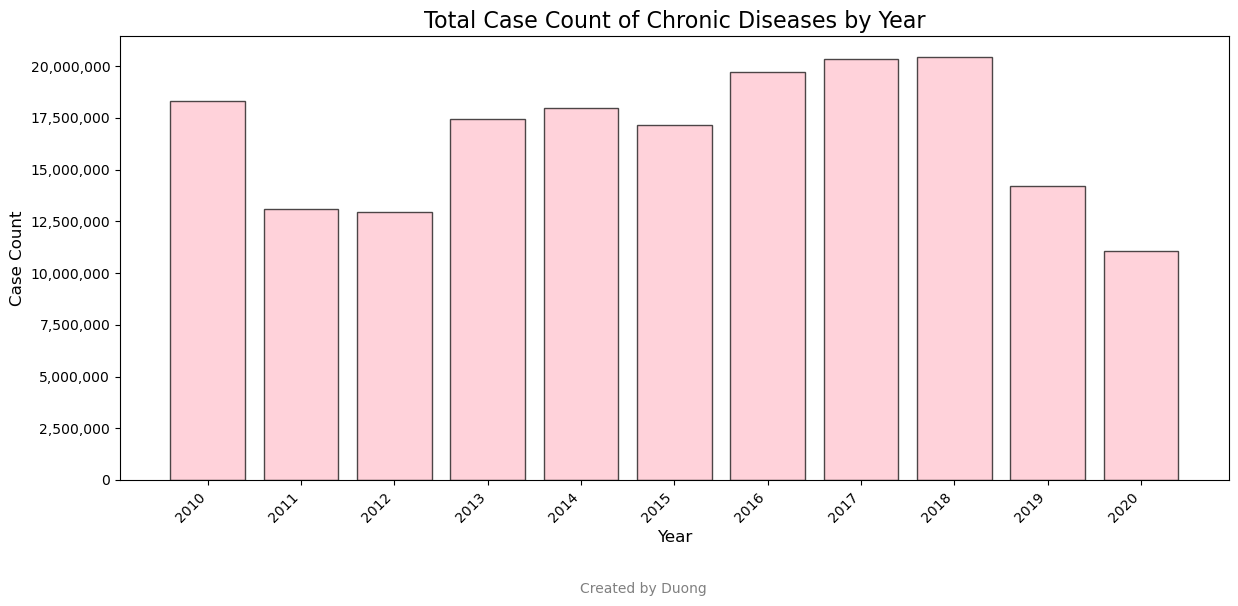

In [6]:
# Viz 1
duongdf = cdi_df[cdi_df["StratificationCategory1"] == "Overall"]

# Prefiltering
table1 = duongdf[
    (duongdf["YearStart"] == duongdf["YearEnd"])
    & (duongdf["DataValueType"] == "Number")
]

# Sum values for Year Start and Year End
sum_values = table1.groupby(["YearStart", "YearEnd"])["DataValue"].sum().reset_index()

# Create a 'Combination' column to sum YearStart and YearEnd
sum_values["Combination"] = (
    sum_values["YearStart"].astype(str) + " - " + sum_values["YearEnd"].astype(str)
)

# Bar chart
plt.figure(figsize=(12, 6))
plt.bar(
    sum_values["Combination"],
    sum_values["DataValue"],
    color="pink",
    edgecolor="black",
    alpha=0.7,
)
plt.title("Total Case Count of Chronic Diseases by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Case Count", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.figtext(
    0.5, 0.01, "Created by Duong", ha="center", va="center", fontsize=10, color="gray"
)

# Making labels for X-axis
plt.gca().set_xticks(range(len(sum_values)))
plt.gca().set_xticklabels(sum_values["YearStart"].astype(str))

# Format Y-axis to show the number in millions, not the scientific format
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()

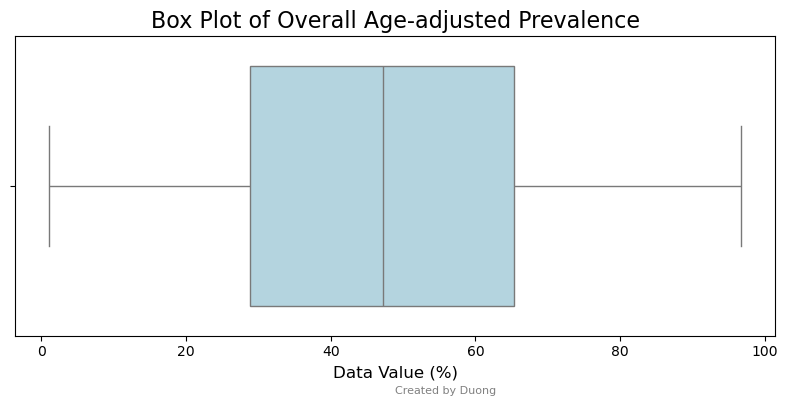

In [7]:
# Viz 2
table2 = duongdf[
    (duongdf["YearStart"] == duongdf["YearEnd"])
    & (duongdf["DataValueType"] == "Age-adjusted Prevalence")
]

plt.figure(figsize=(8, 4))
sns.boxplot(x=table2["DataValue"], color="lightblue")
plt.title("Box Plot of Overall Age-adjusted Prevalence", fontsize=16)
plt.xlabel("Data Value (%)", fontsize=12)
plt.tight_layout()
plt.figtext(
    0.5, 0.01, "Created by Duong", ha="left", va="center", fontsize=8, color="gray"
)
plt.show()

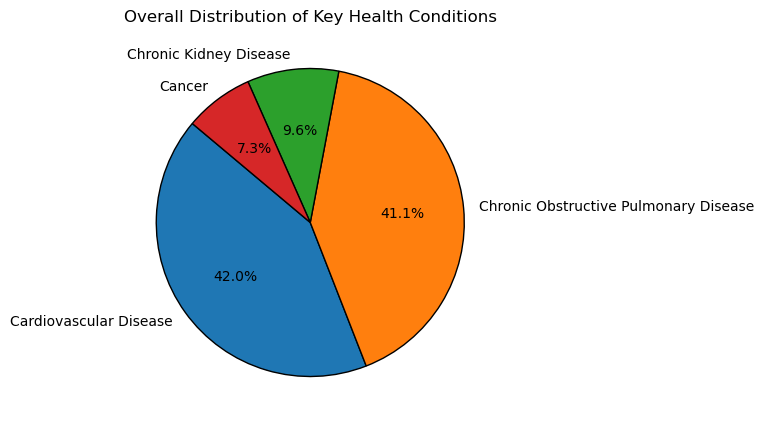

In [8]:
## Created by Ponnu
cdi_df["YearStart"] = cdi_df["YearStart"].astype(int)
cdi_df["YearEnd"] = cdi_df["YearEnd"].astype(int)

cdi_filtered_df = cdi_df[
    (cdi_df["Stratification1"] == "Overall")
    & (cdi_df["LocationAbbr"] != "US")
    & (cdi_df["YearStart"] == cdi_df["YearEnd"])
]
cdi_df_cleaned = cdi_filtered_df.dropna(subset=["DataValue"])

topic = cdi_df_cleaned["Topic"].value_counts()

plt.figure(figsize=(10, 5))
topic.plot(
    kind="pie", autopct="%1.1f%%", startangle=140, wedgeprops={"edgecolor": "black"}
)
plt.title("Overall Distribution of Key Health Conditions")
plt.ylabel("")
plt.show()

In [9]:
cdi_us_overall_questions = [
    "Prevalence of chronic obstructive pulmonary disease among adults >= 45 years",
    "Prevalence of chronic obstructive pulmonary disease among adults >= 18",
    "Prevalence of chronic kidney disease among adults aged >= 18 years",
    "Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease",
    "Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease",
]

cdi_us_overall_df = cdi_us_overall_df[
    (cdi_us_overall_df["Question"].isin(cdi_us_overall_questions))
    & (cdi_us_overall_df["DataValueType"] == "Age-adjusted Prevalence")
]

cdi_us_overall_df = cdi_us_overall_df.drop(columns=["DataValueUnit"])

In [10]:
def plot_baseline_comparison(df):
    df = df.copy()
    df["Year"] = pd.to_datetime(df["Year"])

    topics = df["Topic"].unique()

    for topic in topics:
        topic_df = df[df["Topic"] == topic]

        plot_height = 5 * len(topic_df["Question"].unique())
        plot = (
            so.Plot(topic_df, x="Year", y="DataValue", color="Question")
            .facet(col="Question", wrap=1)
            .share(y=False)
            .add(so.Line(), legend=False)
            .scale(
                x=so.Temporal().tick(upto=20)
            )  # HACK: set 1 tick per year, 20 was a big enough random number
            .label(x="Year", y="DataValue")
            .layout(size=(10, plot_height))
            .theme(sns.axes_style("ticks"))
            .plot(True)
        )

        # HACK: seaborn.objects doesn't support Rule() yet, so working with underlying figure
        for ax in plot._figure.axes:
            ax.axvline(
                x=pd.Timestamp("2020-01-01"),
                color="red",
                linestyle="-",
                alpha=1,
                label="COVID-19",
            )
            ax.legend(loc="upper right")

        # HACK: an overarching title per plot, again need to work with underlying matplotlib figure
        plot._figure.suptitle(topic, y=1, fontweight="bold", fontsize=16)

        plot.show()

In [11]:
def get_forecasted_topic_df(topic_df, method="lm"):
    questions = topic_df["Question"].unique()
    combined_df = []
    for question in questions:
        question_df = topic_df[topic_df["Question"] == question].copy()

        pre_2020_df = question_df[question_df["Year"].dt.year < 2020].copy()
        post_2020_df = question_df[question_df["Year"].dt.year >= 2020].copy()

        question_df["Type"] = "Actual"

        X_pre = pre_2020_df["Year"].dt.year.values.reshape(-1, 1)
        X_post = post_2020_df["Year"].dt.year.values.reshape(-1, 1)

        if len(pre_2020_df) >= 4:
            if method == "lm":
                model = LinearRegression()
                model.fit(X_pre, pre_2020_df["DataValue"])
            elif method == "poly":
                poly = PolynomialFeatures(degree=2, include_bias=False)
                model = make_pipeline(poly, LinearRegression())
                model.fit(X_pre, pre_2020_df["DataValue"])
            elif method == "spline":
                # matching ggplot cubic spline
                spline = SplineTransformer(
                    n_knots=4,  # df + 1
                    degree=3,  # cubic
                    include_bias=False,
                    extrapolation="constant",
                )
                model = make_pipeline(spline, LinearRegression())
                model.fit(X_pre, pre_2020_df["DataValue"])
            else:
                raise ValueError(
                    f"Unknown method: {method}. Use 'lm', 'poly', or 'spline'"
                )
            pred_df = post_2020_df.copy()
            pred_df["DataValue"] = model.predict(X_post)
            pred_df["Type"] = "Predicted"

            combined_df.append(pd.concat([question_df, pred_df], ignore_index=True))
        else:
            combined_df.append(question_df)

    # combined_df is a list of dataframes
    return pd.concat(combined_df, ignore_index=True)

In [12]:
def plot_forecast_comparison(df, method="lm"):
    df = df.copy()
    df["Year"] = pd.to_datetime(df["Year"])

    topics = df["Topic"].unique()
    for topic in topics:
        topic_df = df[df["Topic"] == topic]
        plot_height = 5 * len(topic_df["Question"].unique())

        forecasted_topic_df = get_forecasted_topic_df(topic_df, method)

        actual_df = forecasted_topic_df[forecasted_topic_df["Type"] == "Actual"].copy()
        predicted_df = forecasted_topic_df[
            forecasted_topic_df["Type"] == "Predicted"
        ].copy()

        plot = (
            so.Plot(forecasted_topic_df, x="Year", y="DataValue", color="Question")
            .facet(col="Question", wrap=1)
            .share(x=False, y=False)
            # separate styles are possible for actual and predicted data
            .add(
                so.Line(),
                legend=False,
                data=actual_df,
            )
            .add(
                so.Line(linestyle=(6, 2)),
                legend=False,
                data=predicted_df,
            )
            .scale(
                x=so.Temporal().tick(upto=20)
            )  # HACK: set 1 tick per year, 20 was a big enough random number
            .label(x="Year", y="DataValue")
            .layout(size=(10, plot_height))
            .theme(sns.axes_style("ticks"))
            .plot(True)
        )

        # HACK: seaborn.objects doesn't support Rule() yet, so working with underlying figure
        # Also, because I disabled legends, have to manually add back actual and predicted
        for ax in plot._figure.axes:
            ax.axvline(
                x=pd.Timestamp("2020-01-01"),
                color="red",
                linestyle="-",
                alpha=1,
                label="COVID-19",
            )

            color = ax.get_lines()[0].get_color()
            actual_line = plt.Line2D([], [], color=color, linestyle="-", label="Actual")
            predicted_line = plt.Line2D(
                [], [], color=color, linestyle="--", label="Predicted"
            )
            covid_line = plt.Line2D(
                [], [], color="red", linestyle="-", label="COVID-19"
            )

            # Add legend with all three elements
            ax.legend(
                handles=[actual_line, predicted_line, covid_line], loc="upper left"
            )

        # HACK: an overarching title per plot, again need to work with underlying matplotlib figure
        plot._figure.suptitle(topic, y=1, fontweight="bold", fontsize=16)

        plot.show()

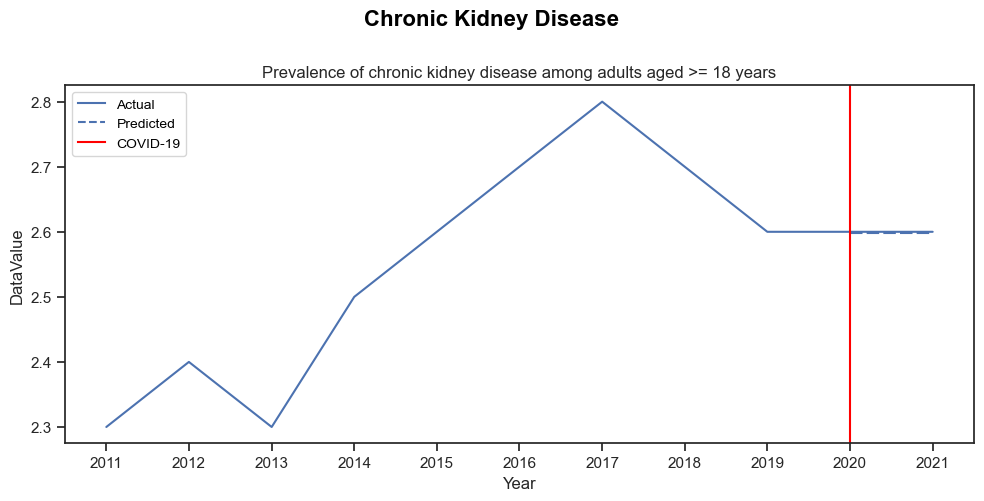

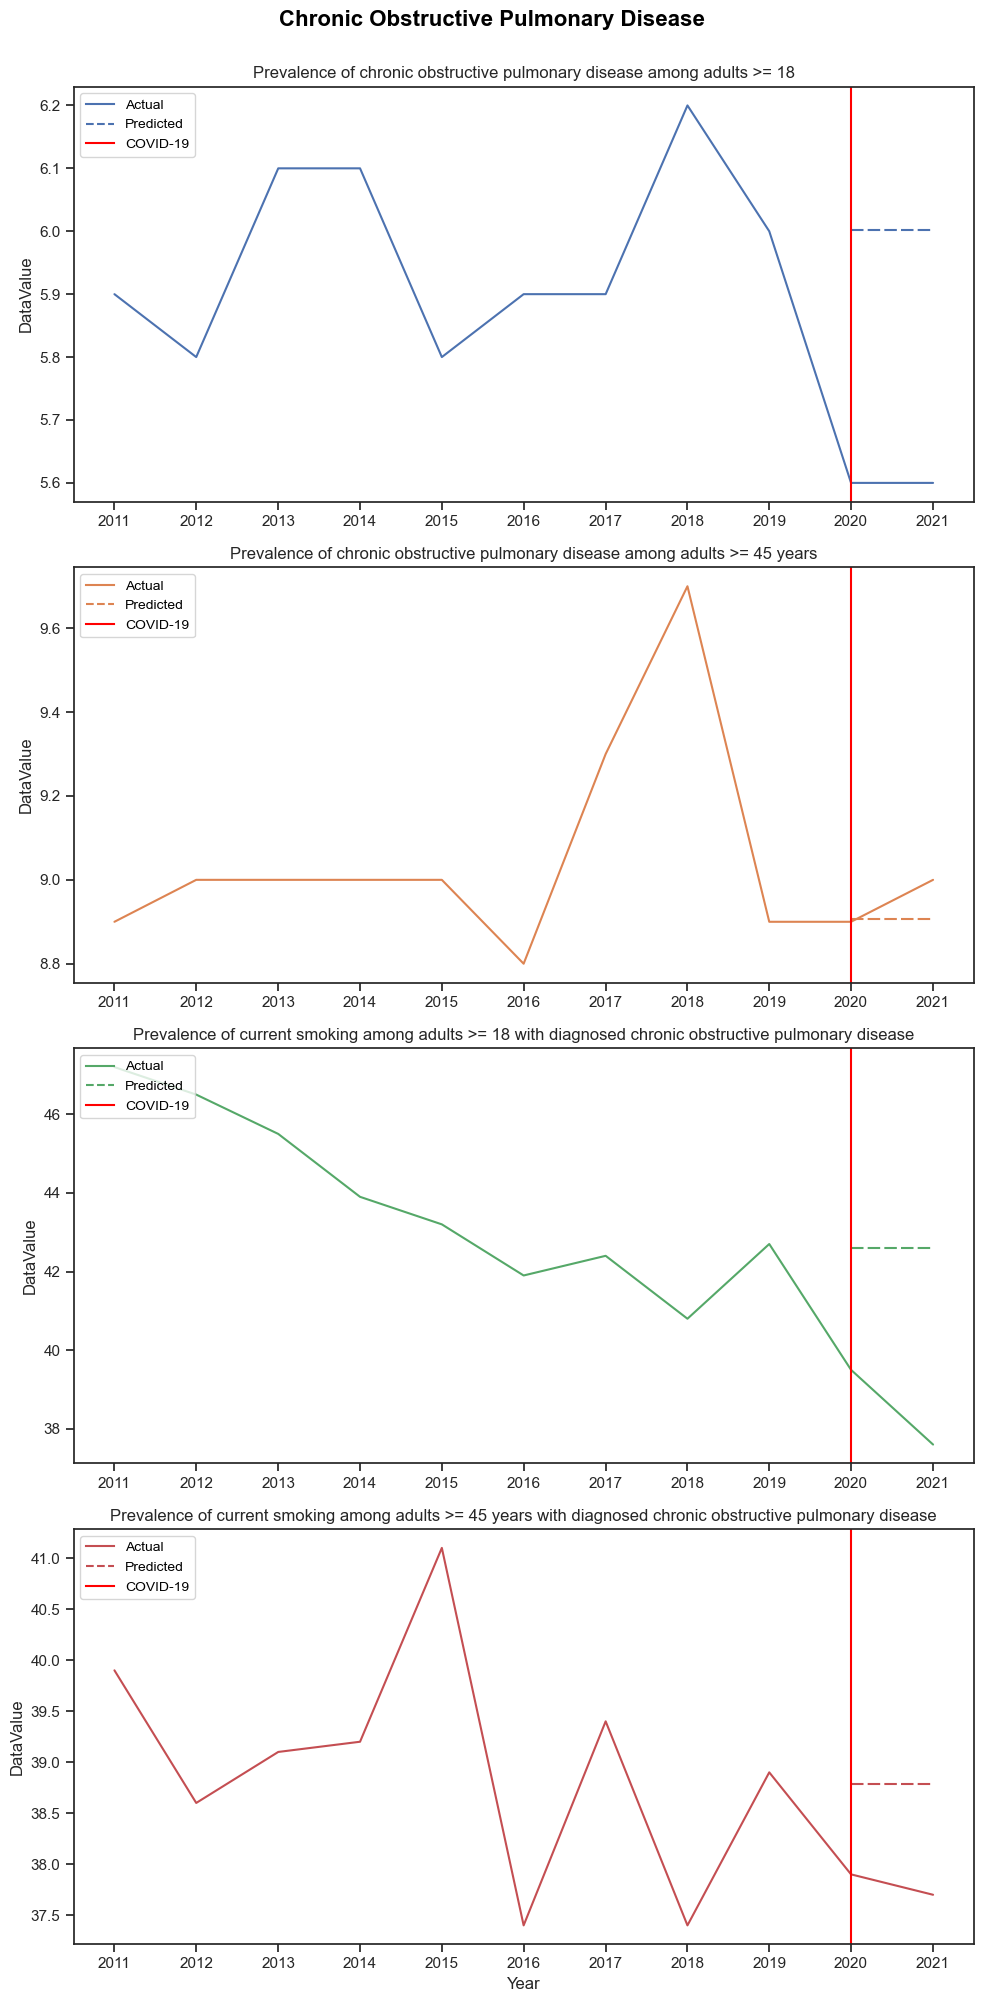

In [13]:
plot_forecast_comparison(cdi_us_overall_df, method="spline")

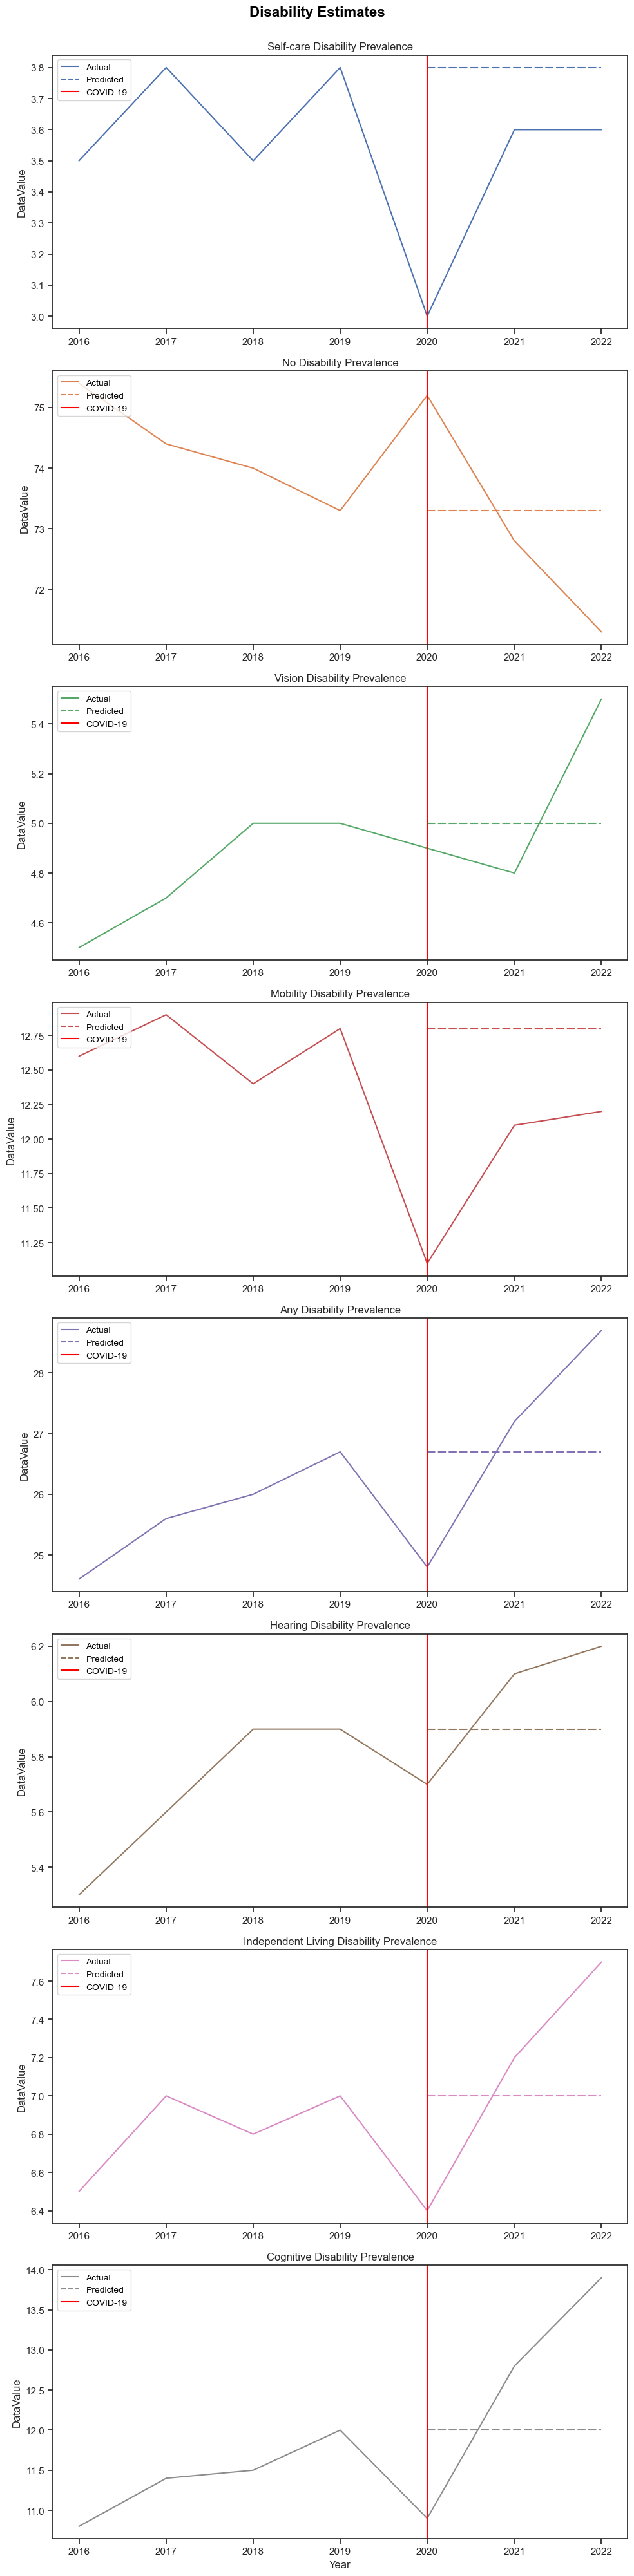

In [14]:
plot_forecast_comparison(disability_df, method="spline")

## Activity 3

Next, we want to think combinations of variables that could be of interest. 

Create a list of combinations of two or more variables that could be of interest to examine (this may not end up being the entirety of what you look at - as we move forward, you might decide to drop some of these, or to look at additional combinations). 

For each of these combinations of variables in this list, specify one or more possible ways that it could be visualized.  

For each of these combinations of variables in this list, either create the visualization(s) you have specified, or identify what is needed before you can do so (again, this could be a matter of needing some data wrangling to be completed, seeking out supplemental data to merge with your dataset, or needing to learn how to do something in R beyond what we have learned so far). 


You can divide up tasks for this, so that each person is focusing on just a few of the visualizations. Remember that for your final submission at the end of the quarter, you will be describing what you each contributed to the project, so make sure that everyone has an opportunity to make approximately equal contributions in this assignment. 

### Combination 1. Topic and Data Value variable
#### Description: 
This tells us the proportion of disease category in our data which is useful for initial data exploration. From this, we can see that the data is not evenly spread and that we may need to find additional cancer data elsewhere

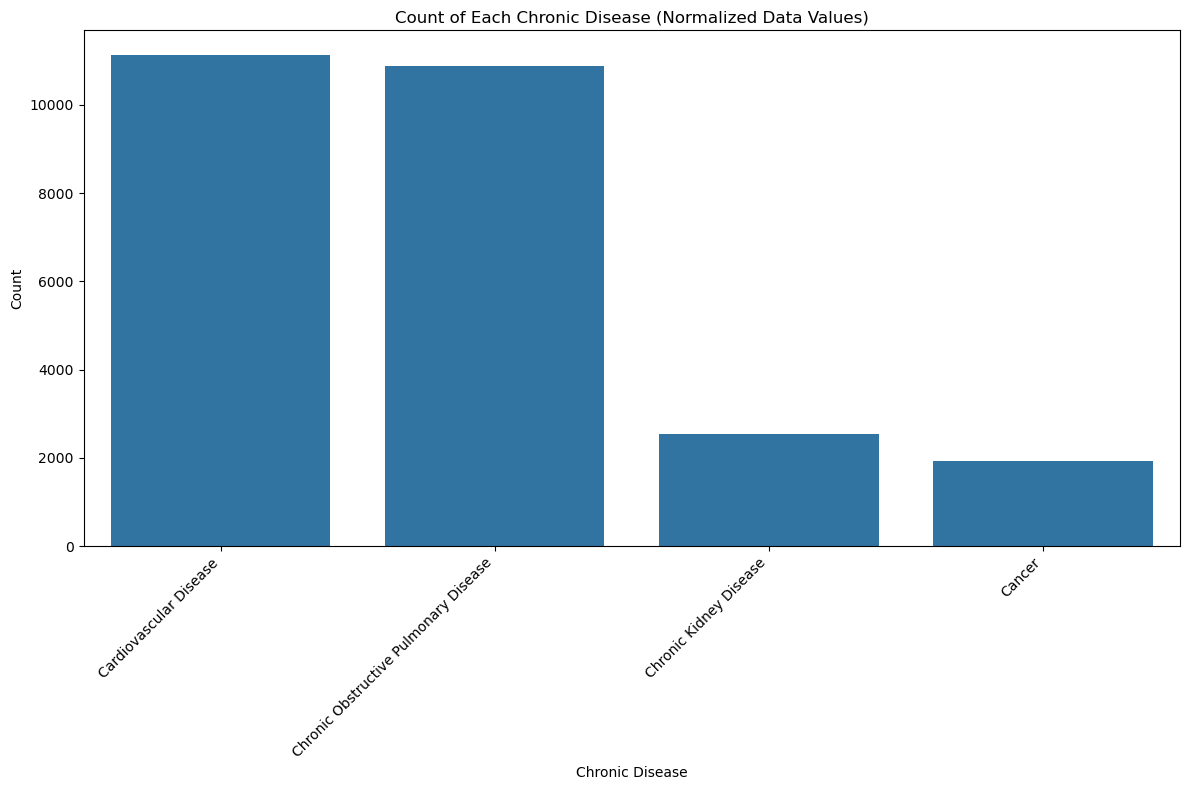

In [15]:
## Done by Lakshit
plt.figure(figsize=(12, 8))
sns.countplot(
    data=cdi_df_cleaned, x="Topic", order=cdi_df_cleaned["Topic"].value_counts().index
)
plt.xticks(rotation=45, ha="right")
plt.title("Count of Each Chronic Disease (Normalized Data Values)")
plt.xlabel("Chronic Disease")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Combination 2: Pre and Post-Covid Comparison + Covid Mortality Curve
##### What needs to be done: 
Since our goal is to show that the changes in the incidence or prevalence of diseases follow Covid's mortality curve, we need to merge that data so we can overlay it -- a simple line again should suffice. The pre and Post-Covid comparison is already available above in Activity 2.

#### Combination 3: Pre and Post-Covid Comparison + Covid Mortality Curve grouped by state or other stratification categories (e.g., race)
##### What needs to be done:
After the 1st combination is completed, we can again extract new insights by separating the data into groups like state or race to see if it impacts certain states or groups more than others. This can be visualized as multiple lines with a legend in each facet.

#### Combination 4: Topic + Question Combination
##### Description: 
Here we can see the prevalence of each disease categorized by its topic. 

In [16]:
def plot_baseline_comparison_per_topic(df):
    df = df.copy()
    df["Year"] = pd.to_datetime(df["Year"])

    plot = (
        so.Plot(df, x="Year", y="DataValue", color="Question")
        .facet(col="Topic", wrap=1)
        .share(x=False, y=False)
        .add(so.Line(), so.Agg())
        .scale(
            x=so.Temporal().tick(upto=20)
        )  # HACK: set 1 tick per year, 20 was a big enough random number
        .label(x="Year", y="DataValue")
        .layout(size=(14, 22))
        .theme(sns.axes_style("ticks"))
        .plot(True)
    )

    # HACK: seaborn.objects doesn't support Rule() yet, so working with underlying figure
    for ax in plot._figure.axes:
        ax.axvline(
            x=pd.Timestamp("2020-01-01"),
            color="red",
            linestyle="-",
            alpha=1,
            label="COVID-19",
        )
        ax.legend(loc="upper right")

    plot.show()

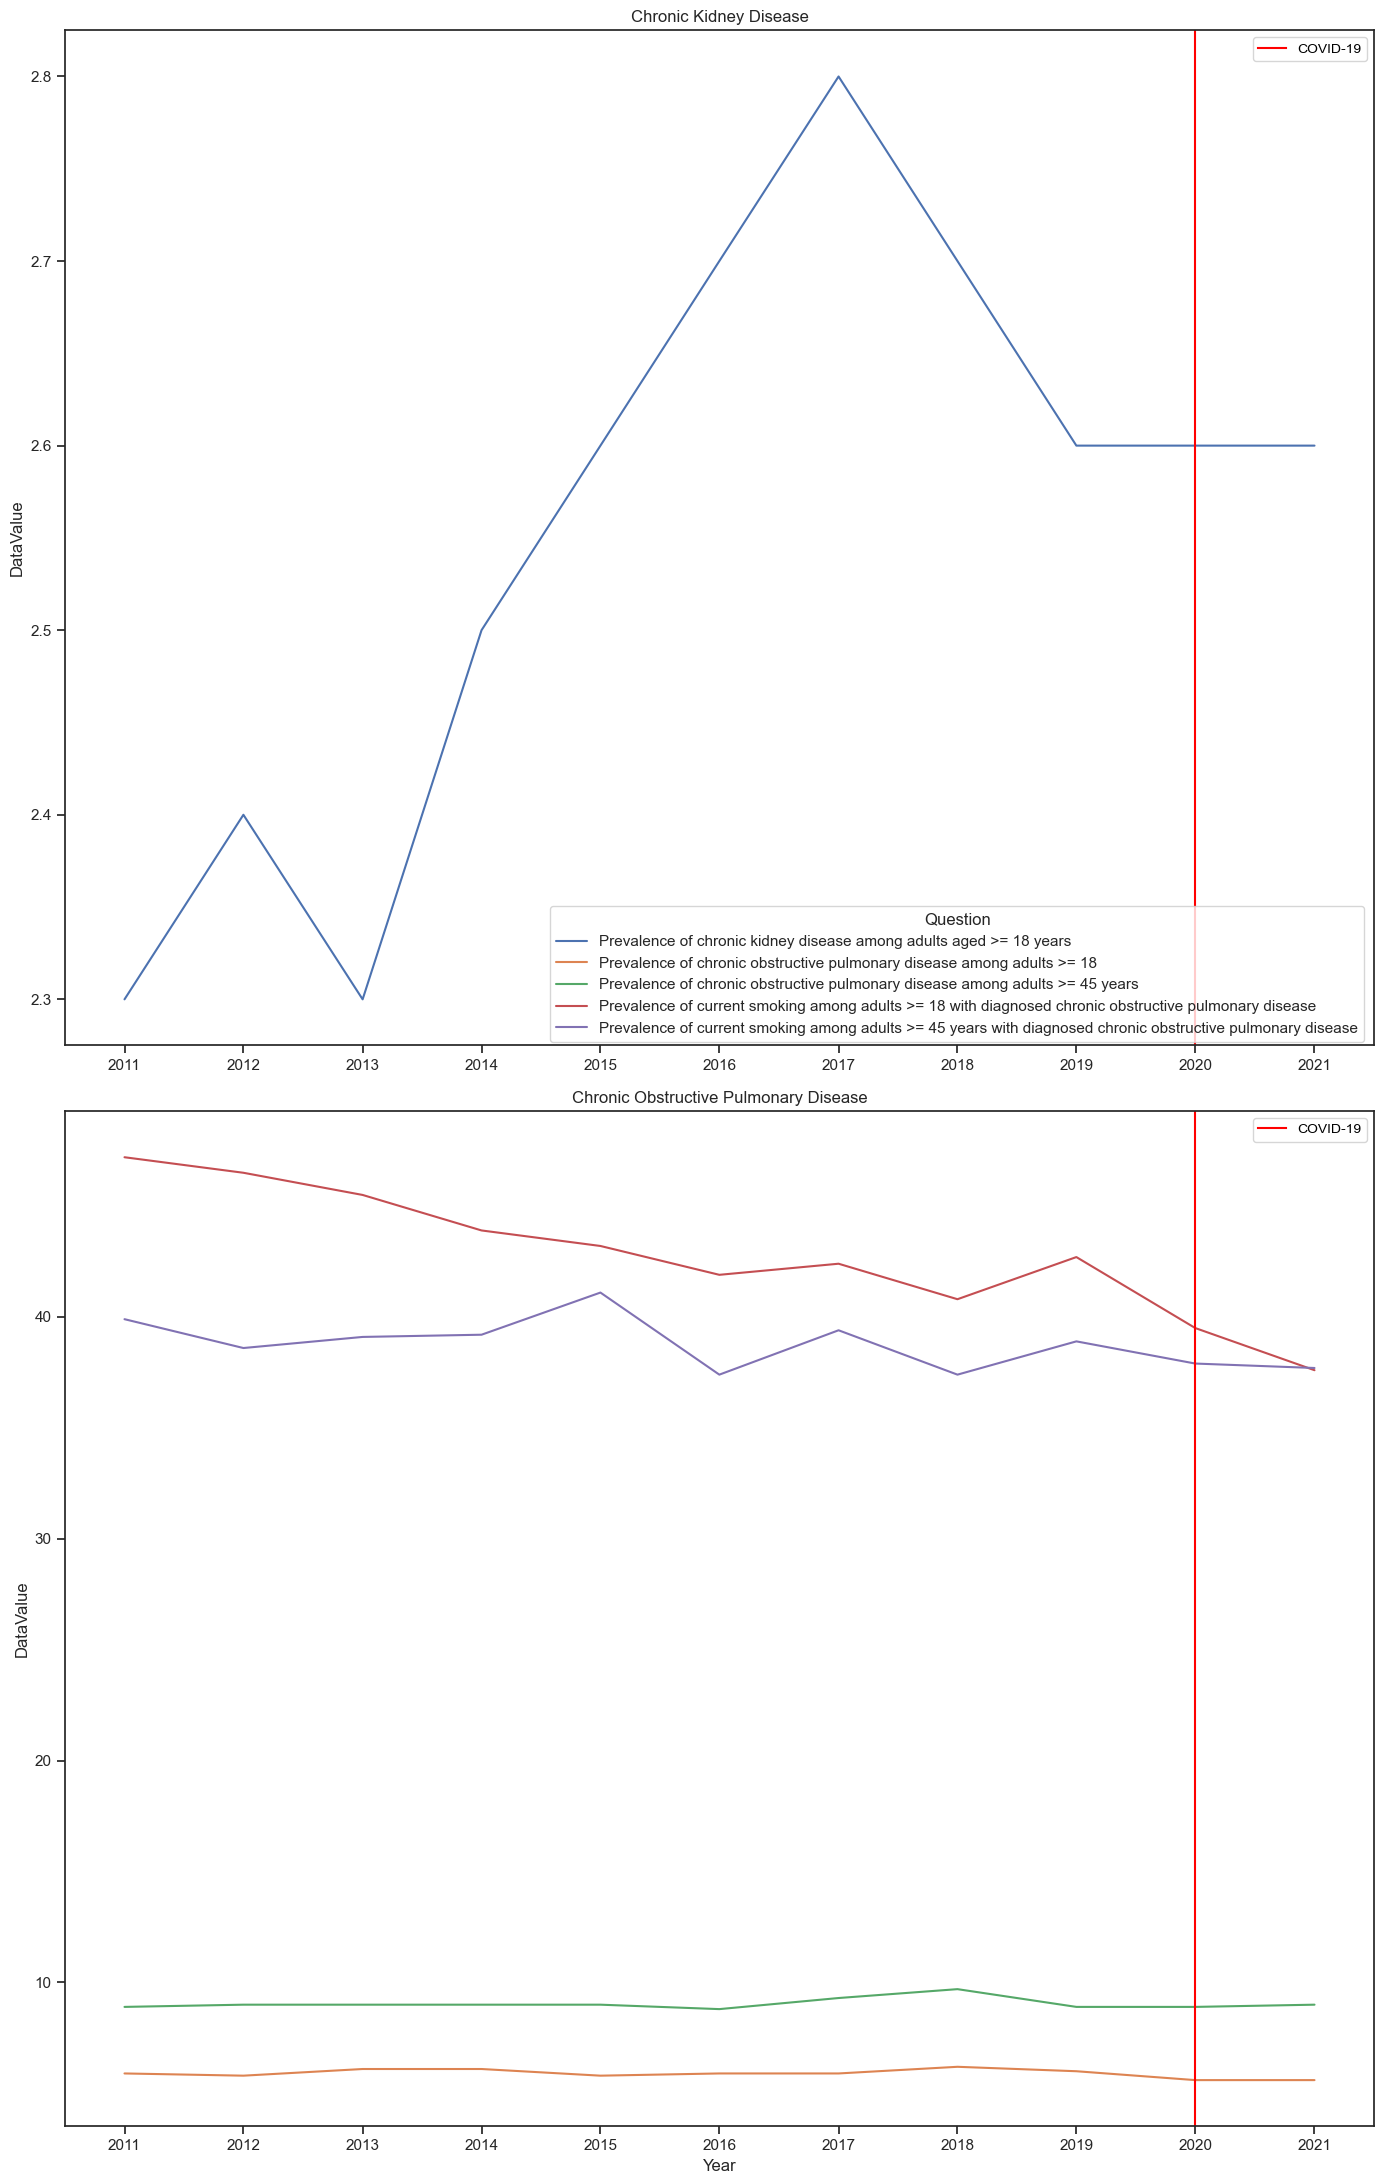

In [17]:
plot_baseline_comparison_per_topic(cdi_us_overall_df)